In [1]:
!pip install smdebug

  Preparing metadata (setup.py) ... done
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl size=6416 sha256=799e96c77fc086d8f0cad3238620f5f6d94fd36d85db77d778347782d43e8c92
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/6c/d4/b3/f7bd451cdb774b086ee5c4791eff9a667fb197759f2f691f66
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [112]:
import os
import math 
import boto3
import sagemaker
import logging
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile,
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from glob import glob
import numpy as np
import requests
import json
import io
import torch
import base64
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#### Configure Logging

In [3]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger("notebook")

#### Environment Variables and SageMaker Session Setup

In [ ]:
# Environment Variables
BUCKET = os.getenv("S3_BUCKET", "default-bucket-name")
ROLE = os.getenv("IAM_ROLE", "default-role")
DEFAULT_REGION = os.getenv("AWS_DEFAULT_REGION", "us-east-1")

In [4]:
# Create a SageMaker session
sagemaker_session = sagemaker.Session()

# Initialize the boto3 session to get the default region
boto3_session = boto3.Session()

# Get the default region, IAM role, and S3 bucket
DEFAULT_REGION = boto3_session.region_name
ROLE = sagemaker.get_execution_role()  # Automatically gets the role associated with the SageMaker notebook or instance
BUCKET= sagemaker_session.default_bucket()  # Automatically gets the default S3 bucket for the SageMaker session

# Log the default values
logger.info(f"Using S3 Bucket: {BUCKET}, IAM Role: {ROLE}, Region: {DEFAULT_REGION}")

2025-01-10 11:53:22,736 - INFO - Using S3 Bucket: sagemaker-us-east-1-517011496817, IAM Role: arn:aws:iam::517011496817:role/service-role/AmazonSageMaker-ExecutionRole-20250109T131016, Region: us-east-1


In [6]:
# SageMaker Session
sagemaker_session = sagemaker.Session()
boto3_session = boto3.Session(region_name=DEFAULT_REGION)
logger.info(f"Using S3 Bucket: {BUCKET}, IAM Role: {ROLE}, Region: {DEFAULT_REGION}")

2025-01-08 09:03:49,711 - INFO - Using S3 Bucket: sagemaker-us-east-1-517011496817, IAM Role: arn:aws:iam::517011496817:role/service-role/AmazonSageMaker-ExecutionRole-20250108T104066, Region: us-east-1


#### Step 1: Download and Prepare Dataset

In [5]:
def download_and_prepare_data():
    """Download and upload the dataset to S3."""
    logger.info("Downloading and preparing dataset...")

    # Create a local data directory if it doesn't exist
    os.makedirs("data", exist_ok=True)
    
    # Download the dataset from the provided S3 URL if not already downloaded
    if not os.path.exists("data/dogImages.zip"):
        logger.info("Downloading dogImages.zip...")
        !aws s3 cp s3://udacity-aind/dog-project/dogImages.zip ./data/ --no-sign-request

    # Unzip the dataset to the local data directory
    logger.info("Unzipping dogImages.zip...")
    !unzip -o data/dogImages.zip -d data

    # Sync the unzipped data to the specified S3 bucket
    s3_data_path = f"s3://{BUCKET}/data/"
    logger.info(f"Uploading data to S3 at {s3_data_path}...")
    !aws s3 sync data/dogImages/ {s3_data_path}

    logger.info(f"Data preparation complete. Dataset uploaded to {s3_data_path}.")
    return s3_data_path

# Call the function to download and prepare the dataset
s3_data_path = download_and_prepare_data()

2025-01-10 11:53:30,780 - INFO - Downloading and preparing dataset...
2025-01-10 11:53:30,782 - INFO - Downloading dogImages.zip...


download: s3://udacity-aind/dog-project/dogImages.zip to data/dogImages.zip


2025-01-10 11:53:41,455 - INFO - Unzipping dogImages.zip...


Archive:  data/dogImages.zip
   creating: data/dogImages/
   creating: data/dogImages/test/
   creating: data/dogImages/train/
   creating: data/dogImages/valid/
   creating: data/dogImages/test/001.Affenpinscher/
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: data/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: data/dogImages/test/002.Afghan_hound/
  inflating: data/dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating: data/dogImages/test/002.Afghan_

2025-01-10 11:53:56,883 - INFO - Uploading data to S3 at s3://sagemaker-us-east-1-517011496817/data/...
2025-01-10 11:54:02,388 - INFO - Data preparation complete. Dataset uploaded to s3://sagemaker-us-east-1-517011496817/data/.


#### Step 2: Hyperparameter Tuning

In [ ]:
logger.info("Perform hyperparameter tuning using SageMaker.")
logger.info("Starting hyperparameter tuning...")

hyperparameter_ranges = {
        "learning_rate": ContinuousParameter(0.001, 0.1),
        "batch_size": CategoricalParameter([32, 64, 128, 256]),
    }

objective_metric_name = "Validation Loss"
metric_definitions = [
        {"Name": "Validation Loss", "Regex": "valid loss: ([0-9\\.]+), acc: [0-9\\.]+.*"},
    ]

estimator = PyTorch(
        entry_point="hpo.py",
        source_dir="code",
        base_job_name="pytorch-dog-hpo",
        role=ROLE,
        framework_version="1.9",
        instance_count=1,
        instance_type="ml.m5.2xlarge",
        py_version="py38",
    )

tuner = HyperparameterTuner(
        estimator,
        objective_metric_name,
        hyperparameter_ranges,
        metric_definitions,
        max_jobs=10,
        max_parallel_jobs=2,
        objective_type="Minimize",
    )

tuner.fit({"training": f"s3://{BUCKET}/data/"}, wait=True)
logger.info("Hyperparameter tuning complete.")

In [6]:
# Initialize SageMaker session
session = sagemaker.Session()

# Define the tuning job name
tuning_job_name = "pytorch-training-250109-1135"  

# Retrieve tuning job results
tuner = HyperparameterTuner.attach(tuning_job_name, sagemaker_session=session)

# Retrieve the best model's hyperparameters
best_training_job = tuner.best_training_job()
print(f"Best training job: {best_training_job}")

# Define the PyTorch estimator for the best training job
estimator = PyTorch.attach(best_training_job, sagemaker_session=session)


Best training job: pytorch-training-250109-1135-009-126c2a70

2025-01-09 13:19:13 Starting - Found matching resource for reuse
2025-01-09 13:19:13 Downloading - Downloading the training image
2025-01-09 13:19:13 Training - Training image download completed. Training in progress.
2025-01-09 13:19:13 Uploading - Uploading generated training model
2025-01-09 13:19:13 Completed - Resource released due to keep alive period expiry


In [7]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-250109-1135',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:517011496817:hyper-parameter-tuning-job/pytorch-training-250109-1135',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Validation Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 10,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"', '"256"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Validation Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"PyTorch"',
   'sagemaker_estimator_modu

In [8]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()


2025-01-09 13:19:13 Starting - Found matching resource for reuse
2025-01-09 13:19:13 Downloading - Downloading the training image
2025-01-09 13:19:13 Training - Training image download completed. Training in progress.
2025-01-09 13:19:13 Uploading - Uploading generated training model
2025-01-09 13:19:13 Completed - Resource released due to keep alive period expiry


In [9]:
# Get the hyperparameters of the best trained model
best_estimator_hyperparameters = best_estimator.hyperparameters()
best_estimator_hyperparameters

{'_tuning_objective_metric': '"Validation Loss"',
 'batch_size': '"64"',
 'learning_rate': '0.002095566960164483',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-dog-hpo-2025-01-09-11-35-18-311"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-517011496817/pytorch-dog-hpo-2025-01-09-11-35-18-311/source/sourcedir.tar.gz"'}

In [11]:
tuner.analytics().dataframe()

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""",0.002176,pytorch-training-250109-1135-010-ef7a85b6,Completed,0.9112,2025-01-09 12:59:34+00:00,2025-01-09 13:19:23+00:00,1189.0
1,"""64""",0.002096,pytorch-training-250109-1135-009-126c2a70,Completed,0.8392,2025-01-09 12:59:31+00:00,2025-01-09 13:19:11+00:00,1180.0
2,"""128""",0.001161,pytorch-training-250109-1135-008-0b87d14e,Completed,1.2444,2025-01-09 12:38:30+00:00,2025-01-09 12:59:18+00:00,1248.0
3,"""32""",0.002018,pytorch-training-250109-1135-007-1956eb6d,Completed,0.8917,2025-01-09 12:38:29+00:00,2025-01-09 12:57:27+00:00,1138.0
4,"""128""",0.032974,pytorch-training-250109-1135-006-5682f465,Completed,4.8711,2025-01-09 12:17:30+00:00,2025-01-09 12:37:58+00:00,1228.0
5,"""32""",0.079234,pytorch-training-250109-1135-005-a85464a0,Completed,4.9096,2025-01-09 12:17:28+00:00,2025-01-09 12:35:20+00:00,1072.0
6,"""256""",0.002996,pytorch-training-250109-1135-004-23e2ebe0,Completed,1.0580,2025-01-09 11:56:29+00:00,2025-01-09 12:17:07+00:00,1238.0
7,"""32""",0.003114,pytorch-training-250109-1135-003-a28104a6,Completed,0.9586,2025-01-09 11:56:27+00:00,2025-01-09 12:14:15+00:00,1068.0
8,"""64""",0.001355,pytorch-training-250109-1135-002-3099f8d1,Completed,0.9361,2025-01-09 11:36:15+00:00,2025-01-09 11:56:08+00:00,1193.0
9,"""64""",0.011399,pytorch-training-250109-1135-001-7560ec91,Completed,2.3405,2025-01-09 11:36:04+00:00,2025-01-09 11:56:07+00:00,1203.0


In [12]:
# Best hyperparameters found:
hyperparameters = {"batch_size": int(best_estimator_hyperparameters['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator_hyperparameters['learning_rate']}

hyperparameters

{'batch_size': 64, 'learning_rate': '0.002095566960164483'}

#### Step 3: Model Training and Profiling

In [13]:
# Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": str(math.ceil(6813 / hyperparameters['batch_size'])), 
        "eval.save_interval": str(math.ceil(968 / hyperparameters['batch_size'])), 
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

2025-01-10 11:57:46,227 - WARNING - Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [33]:
logger.info("Train the model with profiling and debugging enabled.")

estimator = PyTorch(
    entry_point="train_model.py",
    source_dir="code",
    base_job_name="pytorch-dog-training",
    role=ROLE,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    framework_version="1.9",
    py_version="py38",
    hyperparameters=hyperparameters,
    output_path=f"s3://{BUCKET}/output/",
    debugger_hook_config=hook_config,  
    profiler_config=profiler_config,  
    rules=rules,                      
)

estimator.fit({"training": s3_data_path}, wait=True)
logger.info("Model training complete.")

2025-01-10 12:39:53,504 - INFO - Train the model with profiling and debugging enabled.
2025-01-10 12:39:53,704 - INFO - Defaulting to the only supported framework/algorithm version: latest.
2025-01-10 12:39:53,725 - INFO - Ignoring unnecessary instance type: None.
2025-01-10 12:39:53,726 - INFO - Defaulting to the only supported framework/algorithm version: latest.
2025-01-10 12:39:53,746 - INFO - Ignoring unnecessary instance type: None.
2025-01-10 12:39:53,756 - INFO - Defaulting to the only supported framework/algorithm version: latest.
2025-01-10 12:39:54,125 - INFO - Ignoring unnecessary instance type: None.
2025-01-10 12:39:54,127 - INFO - Defaulting to the only supported framework/algorithm version: latest.
2025-01-10 12:39:54,147 - INFO - Ignoring unnecessary instance type: None.
2025-01-10 12:39:54,150 - INFO - Defaulting to the only supported framework/algorithm version: latest.
2025-01-10 12:39:54,169 - INFO - Ignoring unnecessary instance type: None.
2025-01-10 12:39:54,170

2025-01-10 12:39:58 Starting - Starting the training job...
2025-01-10 12:40:26 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2025-01-10 12:41:27 Downloading - Downloading input data......
2025-01-10 12:42:27 Downloading - Downloading the training image........................
2025-01-10 12:46:28 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-01-10 12:46:38,737 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-10 12:46:38,761 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-10 12:46:38,764 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-01-10 12:46:39,028 sagemaker-training-to

2025-01-10 12:54:49,669 - INFO - Model training complete.


Training seconds: 810
Billable seconds: 810


In [34]:
# Print training job information:
print("job name : {}\n".format(estimator.latest_training_job.job_name))
print("latest_job_debugger_artifacts_path : {}\n".format(estimator.latest_job_debugger_artifacts_path()))
print("rule_output_path : {}\n".format(estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"))

job name : pytorch-dog-training-2025-01-10-12-39-53-579

latest_job_debugger_artifacts_path : s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/debug-output

rule_output_path : s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/rule-output



In [35]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2025-01-10 12:56:03.555 default:217 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/debug-output


In [36]:
# List all tensor names
print("Available tensors:")
print(trial.tensor_names())

Available tensors:
[2025-01-10 12:56:05.894 default:217 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-01-10 12:56:06.910 default:217 INFO trial.py:210] Loaded all steps
['cross_entropy_loss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_in

In [37]:
print(f"Train save interval: {hook_config.hook_parameters['train.save_interval']}")
print(f"Eval save interval: {hook_config.hook_parameters['eval.save_interval']}")

Train save interval: 107
Eval save interval: 16


Loaded TRAIN data
Loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


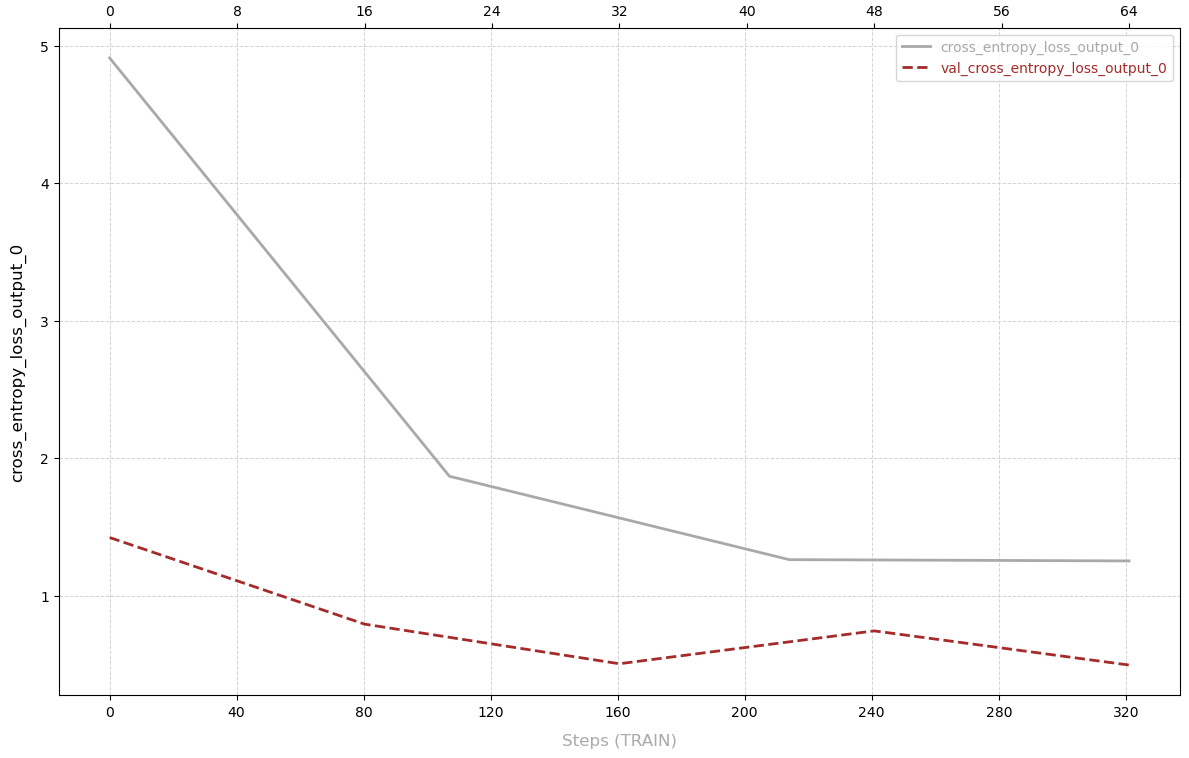

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from matplotlib.ticker import MaxNLocator


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals


def plot_tensor(trial, tensor_name, train_color='darkgray', eval_color='brown', grid_color='lightgray'):
    # Load data
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("Loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("Loaded EVAL data")

    # Create the figure and host subplot
    fig = plt.figure(figsize=(12, 8))
    host = host_subplot(111)
    par = host.twiny()

    # Set labels
    host.set_xlabel("Steps (TRAIN)", fontsize=12, labelpad=10)
    par.set_xlabel("Steps (EVAL)", fontsize=12, labelpad=10)
    host.set_ylabel(tensor_name, fontsize=12, labelpad=10)

    # Plot the data
    p1, = host.plot(steps_train, vals_train, color=train_color, label=tensor_name, linewidth=2)
    print("Completed TRAIN plot")
    p2, = par.plot(steps_eval, vals_eval, color=eval_color, label="val_" + tensor_name, linestyle='--', linewidth=2)
    print("Completed EVAL plot")

    # Configure legend
    leg = plt.legend(loc="upper right", fontsize=10)
    host.xaxis.get_label().set_color(train_color)
    leg.texts[0].set_color(train_color)
    par.xaxis.get_label().set_color(eval_color)
    leg.texts[1].set_color(eval_color)

    # Customize grid
    host.grid(visible=True, color=grid_color, linestyle='--', linewidth=0.7)
    par.grid(visible=False)  # Grid for secondary x-axis is not typically shown

    # Additional plot customization
    host.xaxis.set_major_locator(MaxNLocator(integer=True))
    par.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()

    # Show the plot
    plt.show()


# Example call with custom colors
plot_tensor(trial, "cross_entropy_loss_output_0", grid_color='lightgray')

In [40]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/rule-output'

In [41]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-

In [43]:
latest_training_job = estimator.latest_training_job
description = latest_training_job.describe()
description

{'TrainingJobName': 'pytorch-dog-training-2025-01-10-12-39-53-579',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:517011496817:training-job/pytorch-dog-training-2025-01-10-12-39-53-579',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '64',
  'learning_rate': '"0.002095566960164483"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-dog-training-2025-01-10-12-39-53-579"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-517011496817/pytorch-dog-training-2025-01-10-12-39-53-579/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.9-gpu-py38',
  'TrainingInputMode': 'File',
  'Enable

In [44]:
# get the autogenerated folder name of profiler report
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary() if "Profiler" in rule["RuleConfigurationName"]][0]

#### Step 4: Model Deployment

In [89]:
import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

# Define serializers and deserializers
jpeg_serializer = IdentitySerializer(content_type="image/jpeg")
json_deserializer = JSONDeserializer()

# Define the custom predictor class
class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [90]:
model_location=estimator.model_data
model_location

's3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/output/model.tar.gz'

In [104]:
from sagemaker.pytorch import PyTorchModel

model_location = estimator.model_data

pytorch_inference_model = PyTorchModel(
    entry_point="inference.py",
    source_dir="code",
    role=ROLE,
    model_data=model_location,
    framework_version="1.9",
    py_version="py38",
    predictor_cls=ImagePredictor,
)

logger.info("Deploying the trained model to a SageMaker endpoint...")
predictor = pytorch_inference_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large',
)
logger.info("Model deployed.")
logger.info(f"Endpoint deployed at: {predictor.endpoint_name}")

2025-01-10 15:15:20,329 - INFO - Deploying the trained model to a SageMaker endpoint...
2025-01-10 15:15:20,608 - INFO - Repacking model artifact (s3://sagemaker-us-east-1-517011496817/output/pytorch-dog-training-2025-01-10-12-39-53-579/output/model.tar.gz), script artifact (code), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-517011496817/pytorch-inference-2025-01-10-15-15-20-373/model.tar.gz. This may take some time depending on model size...
2025-01-10 15:15:28,379 - INFO - Creating model with name: pytorch-inference-2025-01-10-15-15-28-379
2025-01-10 15:15:29,106 - INFO - Creating endpoint-config with name pytorch-inference-2025-01-10-15-15-29-106
2025-01-10 15:15:29,434 - INFO - Creating endpoint with name pytorch-inference-2025-01-10-15-15-29-106


------------------------!

2025-01-10 15:28:02,003 - INFO - Model deployed.
2025-01-10 15:28:02,005 - INFO - Endpoint deployed at: pytorch-inference-2025-01-10-15-15-29-106


#### Additional: Interact with the Deployed Model

In [105]:
# load list of dog names
dog_names = [item[25:] for item in sorted(glob("data/dogImages/train/*/"))] 
dog_names

['Affenpinscher/',
 'Afghan_hound/',
 'Airedale_terrier/',
 'Akita/',
 'Alaskan_malamute/',
 'American_eskimo_dog/',
 'American_foxhound/',
 'American_staffordshire_terrier/',
 'American_water_spaniel/',
 'Anatolian_shepherd_dog/',
 'Australian_cattle_dog/',
 'Australian_shepherd/',
 'Australian_terrier/',
 'Basenji/',
 'Basset_hound/',
 'Beagle/',
 'Bearded_collie/',
 'Beauceron/',
 'Bedlington_terrier/',
 'Belgian_malinois/',
 'Belgian_sheepdog/',
 'Belgian_tervuren/',
 'Bernese_mountain_dog/',
 'Bichon_frise/',
 'Black_and_tan_coonhound/',
 'Black_russian_terrier/',
 'Bloodhound/',
 'Bluetick_coonhound/',
 'Border_collie/',
 'Border_terrier/',
 'Borzoi/',
 'Boston_terrier/',
 'Bouvier_des_flandres/',
 'Boxer/',
 'Boykin_spaniel/',
 'Briard/',
 'Brittany/',
 'Brussels_griffon/',
 'Bull_terrier/',
 'Bulldog/',
 'Bullmastiff/',
 'Cairn_terrier/',
 'Canaan_dog/',
 'Cane_corso/',
 'Cardigan_welsh_corgi/',
 'Cavalier_king_charles_spaniel/',
 'Chesapeake_bay_retriever/',
 'Chihuahua/',
 'C

In [106]:
def softmax(logits):
    """
    Computes the softmax of a 1D array of logits.
    """
    return np.exp(logits) / np.sum(np.exp(logits))

def display_prediction(image_url):
    """
    Fetches an image from a given URL, sends it to a deployed model for prediction,
    and displays the image along with the predicted breed and its probability.
    """
    try:
        # Fetch the image from the URL
        logger.info(f"Fetching image from URL: {image_url}")
        image_bytes = requests.get(image_url).content

        # Send the image to the deployed model
        logger.info("Sending image to the endpoint for prediction...")
        prediction_response = predictor.predict(image_bytes)
        logger.info(f"Prediction result: {prediction_response}")

        # Parse the prediction response
        logits = np.array(prediction_response)  # Assuming the response is a list of logits
        predicted_index = np.argmax(logits)
        predicted_probability = softmax(logits)[predicted_index]

        # Display the image and prediction
        display(Image.open(io.BytesIO(image_bytes)))
        print(f"Identified breed: {dog_names[predicted_index]}")
        print(f"Probability: {predicted_probability:.4f}")

    except Exception as e:
        logger.error(f"Error during prediction: {str(e)}")
        raise

In [ ]:
image_url = 'https://dog.ceo/api/img/retriever-golden/n02099601_2084.jpg'
display_prediction(image_url)

#### Clean Up Resources

In [ ]:
logger.info("Deleting the endpoint...")
predictor.delete_endpoint()
logger.info("Endpoint deleted.")